<a href="https://colab.research.google.com/github/ashwinigit123/DataMining/blob/main/Assignment3_Ashwini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1728]:
import pandas as pd
#open the text file that needs to be read and converted to CSV
#note: add the text file on drive to run
imdb_file = open(r"/content/drive/MyDrive/sentimentAnalysis/imdb.txt", "r")
def convertTextToCSV(file):
    lines=file.readlines()
    file.close()
    rev_sentiments=[]
    for l in lines:
        x=l.split('\t')
        rev_sentiments.append([str.lstrip(str.rstrip(x[0])),str.lstrip(str.rstrip(x[1]))])
    return rev_sentiments

rs_list=convertTextToCSV(imdb_file)
review_sentiment_DF=pd.DataFrame(rs_list,columns=['REVIEW','SENTIMENT'])
review_sentiment_DF.to_csv('imdb.csv', index = None)
df = pd.read_csv('imdb.csv')
df.head()

,REVIEW,SENTIMENT
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [1729]:
df.describe()

,SENTIMENT
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


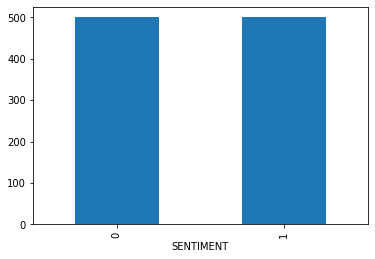

In [1730]:
import matplotlib.pyplot as plt

review_sentiment_DF.groupby('SENTIMENT').REVIEW.count().plot.bar(ylim=0)
plt.show()


In [1731]:
train_split = int(0.8 * len(df))
print(train_split)
dev_split = int(0.9 * len(df))
print(dev_split)
train_set = review_sentiment_DF[:train_split]
dev_set = review_sentiment_DF[train_split:dev_split]
test_set = review_sentiment_DF[dev_split:]

800
900


In [1732]:
train_set.head(5)

,REVIEW,SENTIMENT
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [1733]:
dev_set

,REVIEW,SENTIMENT
800,"In fact, this stinker smells like a direct-to-...",0
801,Avoid at ALL costs!,0
802,Star Trek V The final Frontier is the worst in...,0
803,The acting from all involved and that includes...,0
804,The attempts at humor were pitiful and story i...,0
...,...,...
895,There aren't death scenes like in previous mov...,0
896,"I felt asleep the first time I watched it, so ...",0
897,"The fact is, this film is a wonderful, heartwa...",1
898,"The best part about ""Nurse Betty"" is it's unpr...",1


In [1734]:
test_set

,REVIEW,SENTIMENT
900,"Otherwise, don't even waste your time on this.",0
901,This one just fails to create any real suspense.,0
902,"As for the killer, don't expect anything origi...",0
903,"There is, however, some pretty good acting (at...",1
904,I'm so sorry but I really can't recommend it t...,0
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [1735]:
#Calculating the probability of any word in the given document.
def wordProbabiltity(data,word,numofDoc):
    data_dictionary=dict(data)
    if word in data_dictionary.keys():
        return data_dictionary[word] / numofDoc
    else: return 0

In [1736]:
from collections import Counter
#calculating the uniquewords and building the vocabulary by ommitting rare words(Words occuring less than 5 times)
def countUniqueWords(data):
    reviews = data
    vocab = []
    for review in reviews:
        for word in review.split(' '):
                vocab.append(word)
    vocab = Counter(vocab)
    vocab = Counter({k: v for k, v in vocab.items() if v > 5}) #removing rare word if occuring less than 5 times.
    return vocab


In [1737]:
uniqueWordcount = countUniqueWords(list(list(zip(*review_sentiment_DF.values))[0]))

In [1738]:
print("The P['the'] in the given number of documents: ",wordProbabiltity(uniqueWordcount,'the',len(review_sentiment_DF)))

The P['the'] in the given number of documents:  0.655


In [1739]:
print("The P['a'] in the given number of documents: ",wordProbabiltity(uniqueWordcount,'a',len(review_sentiment_DF)))

The P['a'] in the given number of documents:  0.411


In [1740]:
import numpy as np
#calculate the conditional Probability of given words based on sentiments
def calulateConditionalProbabilty(A,B,word,givenSentiment):
    #Grouping the Similar sentiments together 
    sentimentGroup = np.unique(B)
    dictionary = dict()
    #creating a dictionary of of sentiments.
    for sentiment in sentimentGroup:
        dictionary[sentiment] = A[np.where(B == sentiment)]

    #Counting postive words and negative words
    countPostivewords = dict(countUniqueWords(dictionary['1']))
    countNegativeWords = dict(countUniqueWords(dictionary['0']))
    
    #caculating the probabilty for the given sentiment
    if givenSentiment == '1':
        if word in countPostivewords.keys():
            return countPostivewords[word]/ len(dictionary['1'])
        else: return 0
    else:
        if word in countNegativeWords.keys():
            return countNegativeWords[word]/ len(dictionary['0'])
        else: return 0


In [1741]:
#caculating the conditional probability for the given sentiment is 1.
A = train_set['REVIEW'].values
B = train_set['SENTIMENT'].values

print(" The P['the'|positive] is:", calulateConditionalProbabilty(A,B,'the','1'))


 The P['the'|positive] is: 0.694300518134715


In [1742]:
#Calculating the probability of each sentiment
def probabilityOfSentiment(sentiment,dataset):
  return list(dataset).count(sentiment) / len(list(dataset))

In [1743]:
#defining the naive bayes classifer
class NaiveBayes:
    def __init__(self,X,y,test,alpha,flag):
        self.alpha = alpha
        self.X = X
        self.y = y
        self.test = test
        self.sentiment = np.unique(y)
        self.flag = flag
        
    def naiveBayesAlgo(self,word,sentiment):
        probWordGivenSentiment = calulateConditionalProbabilty(self.X,self.y,word,sentiment)
        
        probOfSentiment = probabilityOfSentiment(sentiment,self.y)
        
        countUniqueWordsInDataset = countUniqueWords(list(self.X))
        probOfWordOccur = wordProbabiltity(countUniqueWordsInDataset,word,len(self.X))
        
        if probOfWordOccur == 0:
            probOfWordOccur = 0.0000001
        if self.alpha == 0:
            return (probWordGivenSentiment*probOfSentiment)/probOfWordOccur  #withouth smoothing
        else:
            if word in self.wordcount.keys():
                count = self.wordcount[word]
            else: count = 1
            return ((probWordGivenSentiment*probOfSentiment) + self.alpha) / (probOfWordOccur + count) #with smoothing
        
        
    def NaiveBayespredict(self):
        result = 1
        y_pred = []
        positive = 0
        negative = 0
        self.separated = dict()
        posdict = dict()
        negdict = dict()
        
        self.wordcount = dict(countUniqueWords(self.X)) #vocab list
        
        for i in self.sentiment:
            self.separated[i] = self.X[np.where(self.y == i)] 
        self.countpos = dict(countUniqueWords(self.separated['1']))
        self.countneg = dict(countUniqueWords(self.separated['0']))
        
        if self.flag != True:
            for review in self.test:
                for senti in self.sentiment:
                    for word in review.split():
                        prob = self.naiveBayesAlgo(word,senti)
                        result = result * prob
                    if senti == 1:
                        positive = result
                    else:
                        negative = result

                if positive > negative:
                    y_pred.append('1')
                else: y_pred.append('0')

            return y_pred
        else:
            for word in self.countpos.keys(): 
                prob = self.naiveBayesAlgo(word,'1')
                posdict[word] = prob
            for word in self.countneg.keys(): 
                prob = self.naiveBayesAlgo(word,'0')
                negdict[word] = prob
            return posdict,negdict

In [1744]:
def calculateAccuracy(actual,predicted):
    correctPredict = 0.0
    for y_true, y_pred in zip(actual,predicted):
        if y_true == y_pred:
            correctPredict += 1
    return correctPredict / float(len(actual)) * 100.0

In [1745]:
def cross_valid(data,k,alpha):
    devsize = 1/k
    score = []
    for i in range(1, k + 1):
        devdata = data.sample(frac=devsize, random_state=i, replace=False).copy(deep=True)
        traindata = data.drop(devdata.index, axis=0).copy(deep=True)
        X_dev = devdata['REVIEW'].values
        y_dev = devdata['SENTIMENT'].values
        X_train = traindata['REVIEW'].values
        y_train = traindata['SENTIMENT'].values
        classifer = NaiveBayes(X_train,y_train,X_dev,alpha,flag= False)
        ypred = np.array(classifer.NaiveBayespredict())
        score.append(calculateAccuracy(y_dev,ypred))
    return score

In [1746]:
X_train = train_set['REVIEW'].values
y_train = train_set['SENTIMENT'].values
X_dev = dev_set['REVIEW'].values
y_dev = dev_set['SENTIMENT'].values
classifer = NaiveBayes(X_train,y_train,X_dev,0,0)
ypred = classifer.NaiveBayespredict()
ypred = np.array(ypred)
print("Accuracy on the dev Dataset without smoothing is:",calculateAccuracy(y_dev,ypred))

Accuracy on the dev Dataset without smoothing is: 53.0


In [1747]:
score = cross_valid(train_set,5,1)
print("Accuracy on dev data with smoothing with alpha 1 : {} %".format(np.mean(score)))

Accuracy on dev data with smoothing with alpha 1 : 51.375 %


In [1748]:
score2 = cross_valid(train_set,5,0.001)
print("Accuracy on dev data with smoothing with alpha 0.001 : {} %".format(np.mean(score2)))

Accuracy on dev data with smoothing with alpha 0.001 : 51.375 %


In [1749]:
positive=dict()
wrodcount = dict(uniqueWordcount)
classifer = NaiveBayes(X_train,y_train,0,1,flag=True)
pos, neg = classifer.NaiveBayespredict()

In [1750]:
pos

{'-': 0.03598180845371857,
 '10': 0.10099875156054931,
 'A': 0.06320224719101124,
 'All': 0.1118046885837148,
 'And': 0.0838535164377861,
 'But': 0.04385822070238289,
 'I': 0.005514950971479825,
 'If': 0.07196361690743713,
 'It': 0.021887534199272186,
 "It's": 0.0482729920932168,
 'John': 0.14374888532191904,
 'The': 0.007525804012589897,
 'This': 0.016307740324594255,
 'a': 0.0037994302787150735,
 'about': 0.03007270323859881,
 'acting': 0.0420307948397836,
 'actors': 0.10062421972534333,
 'actually': 0.14374888532191904,
 'all': 0.03495630461922596,
 'also': 0.059337592714988625,
 'an': 0.025749063670411985,
 'and': 0.0038905770302844716,
 'anyone': 0.07759531355036973,
 'are': 0.016076058772687984,
 'as': 0.014838594613875511,
 'at': 0.02826328200860036,
 'be': 0.02372034956304619,
 'beautiful': 0.1677070328755722,
 'because': 0.050374531835205995,
 'being': 0.12578027465667915,
 'best': 0.06758218893050352,
 'better': 0.09170355237770968,
 'but': 0.020121906440478815,
 'by': 0.0277

In [1751]:
neg

{'-': 0.03660602817906189,
 'A': 0.06289013732833958,
 'And': 0.0838535164377861,
 'But': 0.044238180535200566,
 'Even': 0.14392723381487427,
 'I': 0.005430105571918598,
 "I'm": 0.12578027465667915,
 'If': 0.07196361690743713,
 'It': 0.021860971657768215,
 "It's": 0.048094643600261576,
 'Not': 0.12593632958801498,
 'The': 0.007789558826115242,
 'There': 0.06328027465667915,
 'This': 0.016151685393258425,
 'a': 0.0036332293611314034,
 'about': 0.02992582800910627,
 'acting': 0.04244694132334582,
 'all': 0.035171552800378834,
 'also': 0.059411030329734896,
 'am': 0.12578027465667915,
 'an': 0.025436953807740328,
 'and': 0.0036393187760582293,
 'any': 0.06749895963379109,
 'are': 0.015903197925669837,
 'as': 0.014945603709648654,
 'at': 0.02847135525038147,
 'bad': 0.033385687245781476,
 'bad.': 0.08447773616312941,
 'be': 0.023981650843422464,
 'because': 0.050749063670411994,
 'been': 0.09181704687322664,
 'but': 0.02029326087488678,
 'by': 0.027533151128656747,
 'can': 0.05328865234246

In [1752]:
df_pos = pd.DataFrame.from_dict(pos, orient='index')
df_neg = pd.DataFrame.from_dict(neg, orient='index')

In [1753]:
df_pos.sort_values(by=0,ascending=False).head(10)

,0
job,0.167707
beautiful,0.167707
well.,0.143927
enjoyed,0.143927
funny,0.143927
loved,0.143927
makes,0.143749
actually,0.143749
John,0.143749
being,0.125780


In [1754]:
df_neg.sort_values(by=0,ascending=False).head(10)

,0
poor,0.167707
can't,0.167707
whole,0.167707
half,0.167707
Even,0.143927
worse,0.143927
stupid,0.143927
waste,0.126092
Not,0.125936
script,0.125936


In [1755]:
testscore = cross_valid(test_set,5,1)
print("Accuracy on test data with smoothing with alpha 1 : {} %".format(np.mean(testscore)))

Accuracy on test data with smoothing with alpha 1 : 31.0 %
